In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re
import sklearn as sk
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing as pr
from sklearn import metrics as mr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge

In [8]:
df = pd.read_csv('nyc-east-river-bicycle-counts.csv', sep = ",", decimal = ".",
                 infer_datetime_format = True, parse_dates = [0], index_col = [0])
df.head()

,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,2016-04-01 00:00:00,2016-04-01 00:00:00,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
1,2016-04-02 00:00:00,2016-04-02 00:00:00,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2,2016-04-03 00:00:00,2016-04-03 00:00:00,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
3,2016-04-04 00:00:00,2016-04-04 00:00:00,44.1,33.1,0.47 (S),521.0,1067,1440.0,1307.0,4335
4,2016-04-05 00:00:00,2016-04-05 00:00:00,42.1,26.1,0,1416.0,2617,3081.0,2357.0,9471


In [9]:
# будем строить зависимость общего кол-ва заездов на велосипеде от температуры и атмосферных осадков
# удаляем столбец с датой
df = df.set_index('Date')
df.drop('Day',axis = 1,inplace = True)
df.head()

,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
Date,,,,,,,,
2016-04-01 00:00:00,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
2016-04-02 00:00:00,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2016-04-03 00:00:00,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
2016-04-04 00:00:00,44.1,33.1,0.47 (S),521.0,1067,1440.0,1307.0,4335
2016-04-05 00:00:00,42.1,26.1,0,1416.0,2617,3081.0,2357.0,9471


In [10]:
# превращение всех данных в числовые
t = df['Precipitation'].replace(['0.47 (S)'], '0.47')
t = t.replace(['T'], '0')
t = t.astype(float)
df['Precipitation'] = t
df.head(4)

,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
Date,,,,,,,,
2016-04-01 00:00:00,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
2016-04-02 00:00:00,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2016-04-03 00:00:00,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
2016-04-04 00:00:00,44.1,33.1,0.47,521.0,1067,1440.0,1307.0,4335


In [11]:
df.dtypes

High Temp (°F)         float64
Low Temp (°F)          float64
Precipitation          float64
Brooklyn Bridge        float64
Manhattan Bridge         int64
Williamsburg Bridge    float64
Queensboro Bridge      float64
Total                    int64
dtype: object

In [12]:
# имеем 9 признаков и 210 записей данных
df.shape

(210, 8)

In [13]:
df.isnull().sum()
# нулевых знаечний нет

High Temp (°F)         0
Low Temp (°F)          0
Precipitation          0
Brooklyn Bridge        0
Manhattan Bridge       0
Williamsburg Bridge    0
Queensboro Bridge      0
Total                  0
dtype: int64

In [22]:
# уникальные значения
for column in df.columns:
    print(column,':', sep = '')
    print(*df[column].unique(), sep = ', ')

High Temp (°F):
78.1, 55.0, 39.9, 44.1, 42.1, 45.0, 57.0, 46.9, 43.0, 48.9, 62.1, 64.0, 66.0, 73.9, 81.0, 71.1, 68.0, 70.0, 66.9, 60.1, 57.9
Low Temp (°F):
66.0, 48.9, 34.0, 33.1, 26.1, 30.0, 53.1, 44.1, 37.9, 30.9, 46.0, 45.0, 39.9, 44.6, 52.0, 63.0, 50.0, 61.0, 48.0, 54.0, 46.9
Precipitation:
0.01, 0.15, 0.09, 0.47, 0.0, 0.2, 0.16, 0.24, 0.05
Brooklyn Bridge:
1704.0, 827.0, 526.0, 521.0, 1416.0, 1885.0, 1276.0, 1982.0, 504.0, 1447.0, 2005.0, 1045.0, 2840.0, 2861.0, 2770.0, 2384.0, 3147.0, 3871.0, 3501.0, 3450.0, 3436.0, 2975.0, 2055.0, 2798.0, 3463.0, 1997.0, 3343.0, 2486.0, 2375.0, 3199.0
Manhattan Bridge:
3126, 1646, 1232, 1067, 2617, 3329, 2581, 3455, 997, 2387, 3791, 2178, 5395, 5309, 5072, 4316, 4969, 6823, 6951, 6574, 6452, 4907, 3276, 4650, 5978, 3520, 5606, 4152, 4178, 4952
Williamsburg Bridge:
4115.0, 2565.0, 1695.0, 1440.0, 3081.0, 3856.0, 3282.0, 4113.0, 1507.0, 3132.0, 4334.0, 2762.0, 5995.0, 6030.0, 5816.0, 5624.0, 5867.0, 7432.0, 7834.0, 7639.0, 7426.0, 6093.0, 4856.0, 

In [23]:
# кол-во униклаьных значений
df.Precipitation.value_counts()

0.00    126
0.09     21
0.01     21
0.15      7
0.24      7
0.16      7
0.05      7
0.20      7
0.47      7
Name: Precipitation, dtype: int64

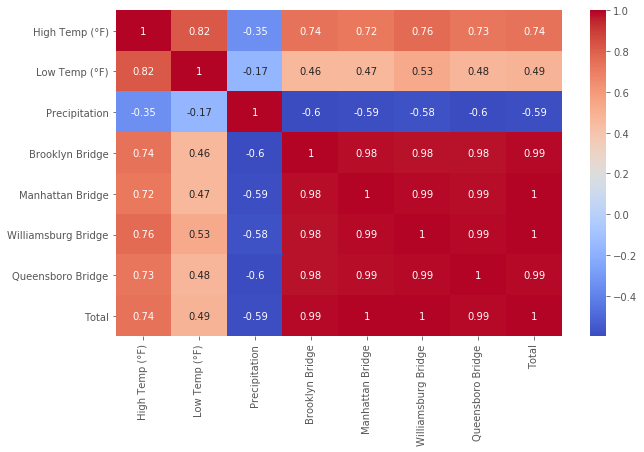

In [27]:
# строим корреляционную матрицу и видим, что наибольшее значение корреляция имеет между 
# целевым признаком и кол-вом заездов на каждом мосту (что очевидно, ибо она функциональная)
# поэтому данные столбцы нам не понадобятся, будем строить модель по 3 первым регрессорам
plt.subplots(figsize = (10,6))
sns.heatmap(df.corr(), cmap = 'coolwarm', annot = True)
plt.show()

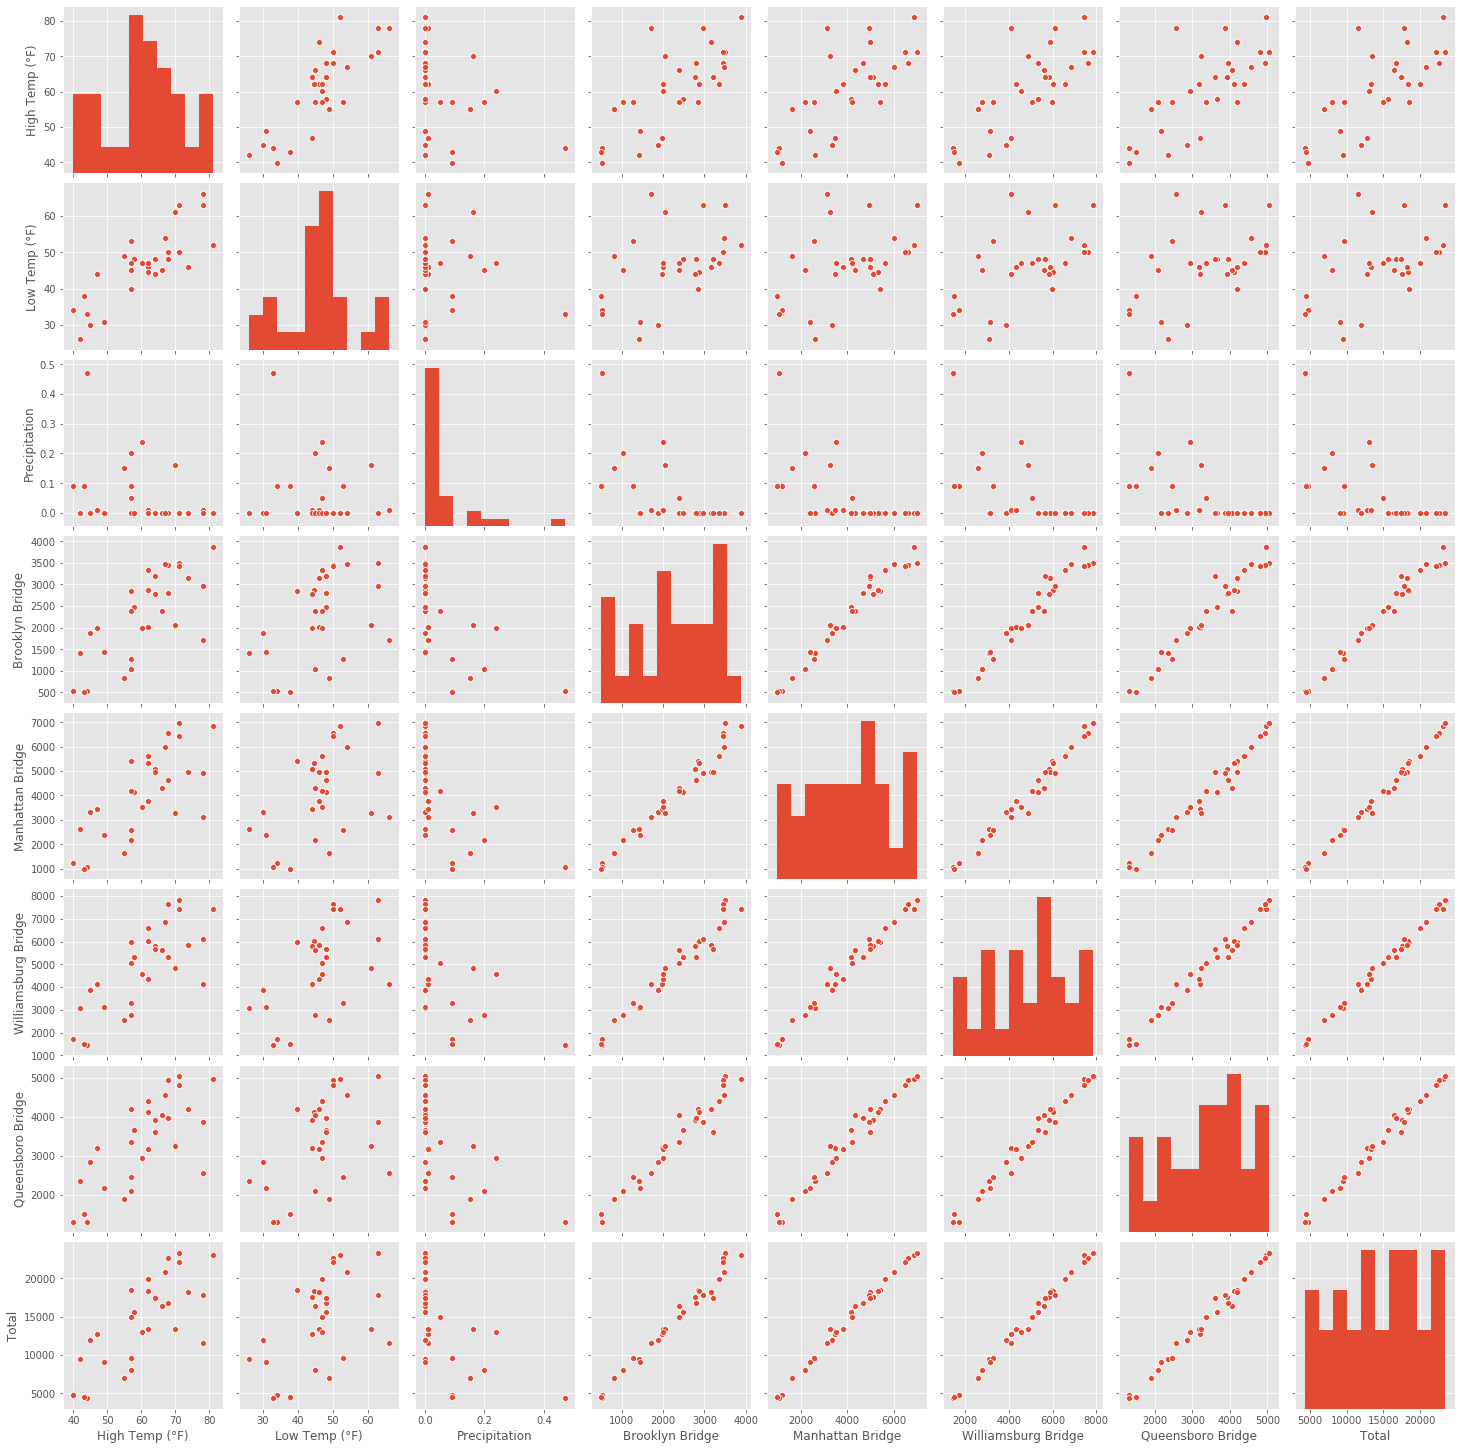

In [28]:
sns.pairplot(df)

In [29]:
# разделение на обучающую и тестовую выборк в соотношении 75 к 25 процентов
x = df.drop(['Total', 'Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge'], axis = 1)
y = df['Total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

Коэффициент детерминации: 0.7112486380544696
Средняя абсолютная ошибка MAE: 2361.855332769307
Средняя квадратичная ошибка: 8255344.117228144
RMSE: 2873.211464063887


Text(0, 0.5, 'Прогнозные данные')

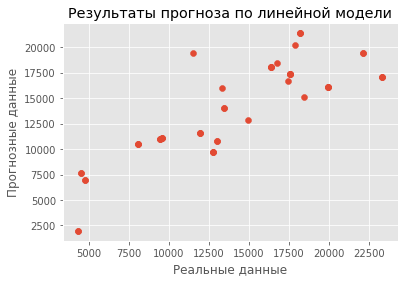

In [52]:
# линейная регрессия с параметрами по умолчанию
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Коэффициент детерминации:', lr.score(x_test, y_test))
print('Средняя абсолютная ошибка MAE:', mr.mean_absolute_error(y_test, y_pred))
print('Средняя квадратичная ошибка:', mr.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mr.mean_squared_error(y_test, y_pred)))
plt.scatter(y_test, y_pred)
plt.title('Результаты прогноза по линейной модели')
plt.xlabel("Реальные данные")
plt.ylabel("Прогнозные данные")

Значение R^2: 0.6804552206627561
Значение MAE: 2439.6646859983844
Значение MSE: 9135721.807574714
Значение RMSE 3022.5356586109474


Text(0, 0.5, 'Прогнозные данные')

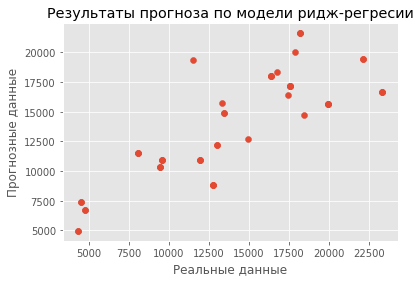

In [53]:
# ридж-регрессия с параметрами по умолчанию
ridge = Ridge()
ridge.fit(x_train, y_train)
ri_y_pred = ridge.predict(x_test)

print('Значение R^2:', ridge.score(x_test, y_test))
print('Значение MAE:', mr.mean_absolute_error(y_test, ri_y_pred))
print('Значение MSE:', mr.mean_squared_error(y_test, ri_y_pred))
print('Значение RMSE', np.sqrt(mr.mean_squared_error(y_test, ri_y_pred)))

plt.scatter(y_test, ri_y_pred)
plt.title('Результаты прогноза по модели ридж-регресии')
plt.xlabel("Реальные данные")
plt.ylabel("Прогнозные данные")

Значение R^2: 0.7111398877421675
Значение MAE: 2362.304311152164
Значение MSE: 8258453.267068547
Значение RMSE 2873.752471433221


Text(0, 0.5, 'Прогнозные данные')

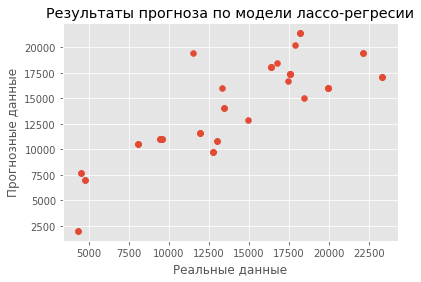

In [55]:
# лассо-регрессия с параметрами по умолчанию
lasso = Lasso()
lasso.fit(x_train, y_train)
la_y_pred = lasso.predict(x_test)

print('Значение R^2:', lasso.score(x_test, y_test))
print('Значение MAE:', mr.mean_absolute_error(y_test, la_y_pred))
print('Значение MSE:', mr.mean_squared_error(y_test, la_y_pred))
print('Значение RMSE', np.sqrt(mr.mean_squared_error(y_test, la_y_pred)))

plt.scatter(y_test, la_y_pred)
plt.title('Результаты прогноза по модели лассо-регресии')
plt.xlabel("Реальные данные")
plt.ylabel("Прогнозные данные")

Значение R^2: 0.6696365961053068
Значение MAE: 2492.6561211152
Значение MSE: 9445024.136038488
Значение RMSE 3073.2757988892713


Text(0, 0.5, 'Прогнозные данные')

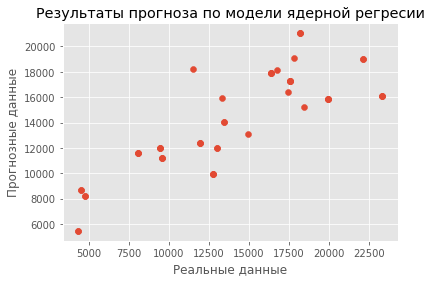

In [57]:
# ядерная регрессия с парметрами по умолчанию
kern = KernelRidge()
kern.fit(x_train, y_train)
ke_y_pred = kern.predict(x_test)

print('Значение R^2:', kern.score(x_test, y_test))
print('Значение MAE:', mr.mean_absolute_error(y_test, ke_y_pred))
print('Значение MSE:', mr.mean_squared_error(y_test, ke_y_pred))
print('Значение RMSE', np.sqrt(mr.mean_squared_error(y_test, ke_y_pred)))

plt.scatter(y_test, ke_y_pred)
plt.title('Результаты прогноза по модели ядерной регресии')
plt.xlabel("Реальные данные")
plt.ylabel("Прогнозные данные")

In [79]:
# лучший коэффициент детерминации - у линейной регрессии
# попробуем применить grid search к линейной регрессии
from sklearn.model_selection import GridSearchCV
model = lr
parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
grid = GridSearchCV(model, parameters)
grid.fit(x_train, y_train)
print("Коэффициент детерминации: ", grid.best_score_)
print("Сумма квадратов остатков: %.2f"
              % np.mean((grid.predict(x_test) - y_test) ** 2))
# коэффициент детерминации не улучшился

Коэффициент детерминации:  0.6458829831890063
Сумма квадратов остатков: 8255344.12


In [71]:
# попробуем построить модель полиномиальной регрессии с grid search сразу
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score 
degrees = [2, 3, 4, 5, 6] # степени
normalizes = [True, False] # нормализовать или нет
# значение параметров, инициализация
best_score = 0
best_degree = 0
for degree in degrees:
    for normalize in normalizes:
        poly_features = PolynomialFeatures(degree = degree)
        x_train_poly = poly_features.fit_transform(x_train)
        polynomial_regressor = LinearRegression(normalize=normalize)
        polynomial_regressor.fit(x_train_poly, y_train)
        scores = cross_val_score(polynomial_regressor, x_train_poly, y_train, cv = 5)
        if max(scores) > best_score:
            best_score = max(scores)
            best_degree = degree
            best_normalize = normalize

In [80]:
print('Лучший коэффициент детерминации:', best_score)
print('Нормализация:', best_normalize)
print('Лучшее значение степени для полинома:', best_degree)

Лучший коэффициент детерминации: 1.0
Нормализация: True
Лучшее значение степени для полинома: 5


In [84]:
# подбираем модель
poly_features = PolynomialFeatures(degree = best_degree)
x_train_poly = poly_features.fit_transform(x_train)
best_polynomial_regressor = LinearRegression(normalize=best_normalize)
best_polynomial_regressor.fit(x_train_poly, y_train)
x_test_poly = poly_features.fit_transform(x_test)
pol_y_pred = best_polynomial_regressor.predict(x_test_poly)

Значение R^2: 1.0
Значение MAE: 4.5974299592791865e-06
Значение MSE: 3.058229560578321e-11
Значение RMSE: 5.530126183531729e-06


Text(0, 0.5, 'Прогнозные данные')

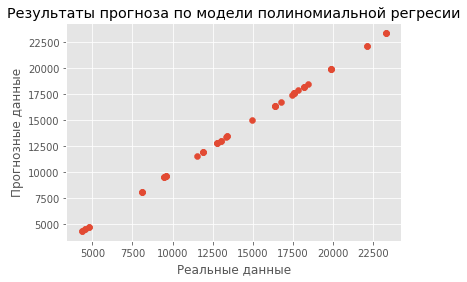

In [86]:

print('Значение R^2:', best_polynomial_regressor.score(x_test_poly, y_test))
print('Значение MAE:', mr.mean_absolute_error(y_test, pol_y_pred))
print('Значение MSE:', mr.mean_squared_error(y_test, pol_y_pred))
print('Значение RMSE:', np.sqrt(mr.mean_squared_error(y_test, pol_y_pred)))

plt.scatter(y_test, pol_y_pred)
plt.title('Результаты прогноза по модели полиномиальной регресии')
plt.xlabel("Реальные данные")
plt.ylabel("Прогнозные данные")
# получили минимальные значения ошибок и коэффициент детерминации = 1